In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import re
from datetime import datetime, timedelta
from geopy.distance import great_circle as GC
# import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
import category_encoders as ce # импорт для работы с кодировщиком
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [8]:
#зададим функцию для одинарного кодирования признака
import category_encoders as ce

def one_fot_encoding(df, column_name):
    encoder = ce.OneHotEncoder(cols=[column_name])
    type_bin = encoder.fit_transform(df[column_name])
    df = pd.concat([df, type_bin], axis=1)
    df.drop([column_name], axis=1, inplace=True) 
    
    return df

In [9]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [11]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [12]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [13]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

**Анализ, очистка и обработка признаков**

Текстовое описание признаков:

* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля

**Признак "hotel_adress" - адрес отеля**

In [16]:
print('There are '+str(data['hotel_address'].nunique())+' different addresses in the dataset.\n')
data['hotel_address'].value_counts().sample(12)

There are 1493 different addresses in the dataset.



10 rue Lamartine 9th arr 75009 Paris France                                 113
2 4bis Cit Rougemont 9th arr 75009 Paris France                              89
Margareteng rtel 142 05 Margareten 1050 Vienna Austria                      167
Bellamyplein 47 Oud West 1053 AT Amsterdam Netherlands                      355
11 rue de Tr vise 9th arr 75009 Paris France                                233
1 Kensington Court Kensington and Chelsea London W8 5DL United Kingdom       86
19 Rue Tronchet 8th arr 75008 Paris France                                  141
Avenida Meridiana 151 Sant Mart 08026 Barcelona Spain                      1061
71 79 Southwark Street Southwark London SE1 0JA United Kingdom              414
33 37 Hogarth Road Kensington and Chelsea London SW5 0QQ United Kingdom    2059
55 57 Avenue Raymond Poincare 16th arr 75016 Paris France                    26
Schottenring 24 01 Innere Stadt 1010 Vienna Austria                         196
Name: hotel_address, dtype: int64

Из данного признака мы можем извлечь данные о стране и городе

In [17]:
#Признак city
data['city'] = data['hotel_address'].apply(lambda x : 'London' if x.split()[-1] == 'Kingdom' else x.split()[-2])

#Признак country
data['country'] = data['hotel_address'].apply(lambda x : 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

display(data['country'].value_counts(), data['city'].value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

Кодируем страну и город

In [18]:
encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)

#удаляем не нужные столбцы
data = data.drop(['hotel_address'],axis=1)

Группируем данные по городу и почтовому индексу для получения средних значений географических координат почтовых индексов, которыми заполняем отсутствующие значения 'lat' и 'lng'

In [19]:
#удаляем не нужные столбцы
data = data.drop(['city'],axis=1)
data = data.drop(['country'],axis=1)

In [20]:
data.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,country_Spain,country_United Kingdom,country_France,country_Austria,city_Milan,city_Amsterdam,city_Barcelona,city_London,city_Paris,city_Vienna
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,0,0,1,0,0,0,0,0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,0,0,1,0,0,0,0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,1,0,0,0,0,0,1,0,0,0
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0,0,0,0,1,0,0,0,0,0
4,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,0,0,0,0,0,1,0,0,0,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

**Признак 'review_date'**

In [22]:
data['review_date'].head()

0     7/21/2017
1    12/12/2016
2    11/26/2015
3    10/17/2015
4     5/16/2016
Name: review_date, dtype: object

In [24]:
data['review_date'] = pd.to_datetime(data['review_date'])#преобразуем в формат datetime

In [25]:
# Выделим 'year', 'day', 'month' and 'weekday' 
# data['week'] = data['review_date'].dt.isocalendar().week

data['year'] = data['review_date'].dt.year
data['day'] = data['review_date'].dt.day
data['month'] = data['review_date'].dt.month
data['weekday'] = data['review_date'].dt.weekday + 1 # Monday = 1, ..., Sunday = 7

In [26]:
display(data['month'].value_counts())

8     50672
7     49318
5     46490
10    43843
6     42896
4     42883
9     42428
1     42151
3     41110
12    39607
2     38370
11    35970
Name: month, dtype: int64

In [27]:
#распределим месяца по сезонам, создав новый признак
data['season'] = data['month'].apply(lambda x: 1 if x in [8,7,5,10] else 0)

In [28]:
data.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,city_Amsterdam,city_Barcelona,city_London,city_Paris,city_Vienna,year,day,month,weekday,season
0,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,0,0,0,2017,21,7,5,1
1,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,1,0,0,0,0,2016,12,12,1,0
2,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,0,1,0,0,0,2015,26,11,4,0
3,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0,0,0,0,0,2015,17,10,6,1
4,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,1,0,0,0,0,2016,16,5,1,1


In [29]:
data['hotel_name'].head()
data['hotel_name'].nunique()
data = data.drop(['hotel_name'],axis=1)

In [30]:
data.head()

,additional_number_of_scoring,review_date,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,city_Amsterdam,city_Barcelona,city_London,city_Paris,city_Vienna,year,day,month,weekday,season
0,904,2017-07-21,8.1,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,0,0,0,2017,21,7,5,1
1,612,2016-12-12,8.6,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,1,0,0,0,0,2016,12,12,1,0
2,46,2015-11-26,8.3,Sweden,Pillows,3,351,Nice welcoming and service,5,15,...,0,1,0,0,0,2015,26,11,4,0
3,241,2015-10-17,9.1,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,0,0,0,0,0,2015,17,10,6,1
4,834,2016-05-16,9.1,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,1,0,0,0,0,2016,16,5,1,1


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   reviewer_nationality                        515738 non-null  object        
 4   negative_review                             515738 non-null  object        
 5   review_total_negative_word_counts           515738 non-null  int64         
 6   total_number_of_reviews                     515738 non-null  int64         
 7   positive_review                             515738 non-null  object        
 8   review_total_positive_word_counts           515738 non-null  int64        

**Признак "reviewer_nationality" - национальность рецензента**

In [32]:
data['reviewer_nationality'].nunique()

227

In [33]:
# удаляем "лишние" пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

# смотрим как распределяются национальности путешественников
data['reviewer_nationality'].value_counts(normalize=True).nlargest(30) * 100

United Kingdom              47.552439
United States of America     6.871124
Australia                    4.204848
Ireland                      2.874909
United Arab Emirates         1.984535
Saudi Arabia                 1.735571
Netherlands                  1.700864
Switzerland                  1.682637
Germany                      1.539735
Canada                       1.530622
France                       1.414672
Israel                       1.281659
Italy                        1.185486
Belgium                      1.169392
Turkey                       1.055575
Kuwait                       0.953973
Spain                        0.918490
Romania                      0.882619
Russia                       0.756198
South Africa                 0.740880
India                        0.666424
Greece                       0.660413
China                        0.659249
Sweden                       0.653045
New Zealand                  0.627644
Singapore                    0.599335
Hong Kong   

In [34]:
# Кодируем признак в двоичный формат

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [35]:
#удаляем столбец "reviewer_nationality"
data = data.drop(['reviewer_nationality'],axis=1)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   negative_review                             515738 non-null  object        
 4   review_total_negative_word_counts           515738 non-null  int64         
 5   total_number_of_reviews                     515738 non-null  int64         
 6   positive_review                             515738 non-null  object        
 7   review_total_positive_word_counts           515738 non-null  int64         
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64        

**Признаки 
"negative_review" - отрицательный отзыв, который рецензент дал отелю и 
"positive_review" - положительный отзыв, который рецензент дал отелю**

In [37]:
data["negative_review"]

0          Would have appreciated a shop in the hotel th...
1               No tissue paper box was present at the room
2                                                  Pillows 
3                                               No Negative
4                                               No Negative
                                ...                        
515733                                          No Negative
515734                                          No Negative
515735     room is really small but guess is normal in L...
515736                                          No Negative
515737     Patio outside could have been cleaned of alga...
Name: negative_review, Length: 515738, dtype: object

In [38]:
data["positive_review"]

0          Hotel was great clean friendly staff free bre...
1                                               No Positive
2                                Nice welcoming and service
3          Everything including the nice upgrade The Hot...
4                           Lovely hotel v welcoming staff 
                                ...                        
515733                   Tr s proche du metro Earl s court 
515734     The bed was so comfy I stayed with my boyfrie...
515735       great location simple check in out nice shower
515736                          Location and very comfy bed
515737     Beds comfortable Pillows also good Homely fee...
Name: positive_review, Length: 515738, dtype: object

Проведем анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER

In [39]:
# удаляем начальные и конечные пробелы в признаке негативных отзывов
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())
data['negative_review'].value_counts().reset_index().head(10)

,index,negative_review
0,No Negative,127890
1,Nothing,18531
2,nothing,2508
3,None,1166
4,N A,1060
5,,849
6,Nothing really,570
7,N a,520
8,All good,470
9,Small room,455


In [40]:
# Создаём объекты SentimentIntensityAnalyzer
positive = SentimentIntensityAnalyzer()
negative = SentimentIntensityAnalyzer()

# меняем некорректные значения в отзывах:
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['positive_review_temp'] = data['negative_review'].apply(lambda x: x.replace('All good', 'Positive'))
data['positive_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No complaints', 'Positive'))
data['positive_review_temp'] = data['negative_review'].apply(lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

In [41]:
%%time

data['negative_review_sentiments'] = data['negative_review_temp'].apply(lambda x: negative.polarity_scores(x))

data['positive_review_sentiments'] = data['positive_review_temp'].apply(lambda x: positive.polarity_scores(x))

# формируем новые признаки:
data['neg_review_sentiments_neg'] = data['negative_review_sentiments'].apply(lambda x: x['neg'])
data['neg_review_sentiments_neu'] = data['negative_review_sentiments'].apply(lambda x: x['neu'])
data['neg_review_sentiments_pos'] = data['negative_review_sentiments'].apply(lambda x: x['pos'])
data['neg_review_sentiments_compound'] = data['negative_review_sentiments'].apply(lambda x: x['compound'])

data['pos_review_sentiments_neg'] = data['positive_review_sentiments'].apply(lambda x: x['neg'])
data['pos_review_sentiments_neu'] = data['positive_review_sentiments'].apply(lambda x: x['neu'])
data['pos_review_sentiments_pos'] = data['positive_review_sentiments'].apply(lambda x: x['pos'])
data['pos_review_sentiments_compound'] = data['positive_review_sentiments'].apply(lambda x: x['compound'])

CPU times: user 4min 33s, sys: 2.79 s, total: 4min 36s
Wall time: 4min 36s


In [42]:
#Удаляем признаки "negative_review" и "positive_review"
data=data.drop(['negative_review'],axis=1)
data=data.drop(['positive_review'],axis=1)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   total_number_of_reviews                     515738 non-null  int64         
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   tags                                        515738 non-null  object        
 8   days_since_review                           515738 non-null  object       

**Признак "days_since_review" - продолжительность между датой проверки и датой очистки**

In [44]:
# выделим число, удалив слова day(s), меняем тип данных на int.
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(re.findall(r'\d+', x)[0])).astype('int16')

In [45]:
data['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int16

In [46]:
data['days_since_review'].max()

730

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   total_number_of_reviews                     515738 non-null  int64         
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   tags                                        515738 non-null  object        
 8   days_since_review                           515738 non-null  int16        

**Признак "tags" - теги, которые рецензент дал отелю**

In [48]:
#  Создаем новый признак count_nights (количество ночей)
def count_nights(tags):
    express = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    row = ''.join(map(str,express))
    if len(row) == 0:
        return 1 # принимаем, что клиент оставаливался минимум на одну ночь
    else:
        return int(row)
data['count_nights'] = data['tags'].apply(count_nights)
data.head()

,additional_number_of_scoring,review_date,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,...,positive_review_sentiments,neg_review_sentiments_neg,neg_review_sentiments_neu,neg_review_sentiments_pos,neg_review_sentiments_compound,pos_review_sentiments_neg,pos_review_sentiments_neu,pos_review_sentiments_pos,pos_review_sentiments_compound,count_nights
0,904,2017-07-21,8.1,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,...,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,2
1,612,2016-12-12,8.6,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.216,0.784,0.000,-0.2960,1.0,0.000,0.000,-0.5719,1
2,46,2015-11-26,8.3,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,41.393192,...,"{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,1
3,241,2015-10-17,9.1,0,1543,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656,45.479888,...,"{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...",0.000,0.000,1.000,0.5574,0.0,0.621,0.379,0.9153,1
4,834,2016-05-16,9.1,0,4687,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444,52.370545,...,"{'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...",0.000,0.000,1.000,0.5574,0.0,0.230,0.770,0.7717,2


In [49]:
#Создаем признак посещение гостя с домашним питомцем
def with_pet(tags):
    for element in tags:
        if 'With a pet' in element:
            return 1
    return 0

data['with_a_pet'] = data['tags'].apply(with_pet)


In [50]:
#Создаем признак отправки отзыва с мобильного телефона
def Sub_from_mobile(tags):
    for element in tags:
        if 'Submitted from a mobile device' in element:
            return 1
    return 0

data['Sub_from_mobile'] = data['tags'].apply(Sub_from_mobile)

In [51]:
#Создаем признак типа поездки get_trip_type: отдых или деловая поездка
def get_trip_type(tags):
    for element in tags:
        if 'trip' in element:
            return element
    return 'Unknown'

data['trip_type'] = data['tags'].apply(get_trip_type)


In [52]:
#Закодируем
one_hot_encoder = ce.OneHotEncoder(cols=['trip_type'], use_cat_names=True)
encoded = one_hot_encoder.fit_transform(data['trip_type'])
if set(one_hot_encoder.get_feature_names()).issubset(data.columns):
    pass
else:
    data = pd.concat([data, encoded], axis=1, join='inner')

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:361: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  category=FutureWarning)


In [53]:
#Создадим признак типа путешественника
def get_traveller_type(tags):
    for element in tags:
        if 'Solo' in element:
            return 'Solo'
        elif 'Group' in element:
            return 'Group'
        elif 'Couple' in element:
            return 'Couple'
        elif 'Family' in element:
            return 'Family'
    return 'Other'

data['traveller_type'] = data['tags'].apply(get_traveller_type)

In [54]:
#Закодируем
one_hot_encoder = ce.OneHotEncoder(cols=['traveller_type'], use_cat_names=True)
encoded = one_hot_encoder.fit_transform(data['traveller_type'])
if set(one_hot_encoder.get_feature_names()).issubset(data.columns):
    pass
else:
    data = pd.concat([data, encoded], axis=1, join='inner')

In [55]:
# Создадим признак типа номеров отеля
def get_room_type(tags):
    for element in tags:
        if 'Room' in element or 'Suite' in element:
            return element
    return 'Unknown Room type'

data['room_type'] = data['tags'].apply(get_room_type)

n = 11
popular_room_types = data['room_type'].value_counts().nlargest(n).index
data['room_type'] = data['room_type'].apply(lambda x: x if x in popular_room_types else 'Other')

In [56]:
#Закодируем
one_hot_encoder = ce.OneHotEncoder(cols=['room_type'], use_cat_names=True)
encoded = one_hot_encoder.fit_transform(data['room_type'])
if set(one_hot_encoder.get_feature_names()).issubset(data.columns):
    pass
else:
    data = pd.concat([data, encoded], axis=1, join='inner')

In [57]:
data.head(3)

,additional_number_of_scoring,review_date,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,...,pos_review_sentiments_compound,count_nights,with_a_pet,Sub_from_mobile,trip_type,trip_type_Unknown,traveller_type,traveller_type_Other,room_type,room_type_Unknown Room type
0,904,2017-07-21,8.1,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13,45.533137,...,0.9615,2,0,0,Unknown,1,Other,1,Unknown Room type,1
1,612,2016-12-12,8.6,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234,52.385649,...,-0.5719,1,0,0,Unknown,1,Other,1,Unknown Room type,1
2,46,2015-11-26,8.3,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616,41.393192,...,0.6908,1,0,0,Unknown,1,Other,1,Unknown Room type,1


In [58]:
#Удалим признак "tags"
data=data.drop(['tags'],axis=1)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   total_number_of_reviews                     515738 non-null  int64         
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   days_since_review                           515738 non-null  int16         
 8   lat                                         512470 non-null  float64      

<AxesSubplot:>

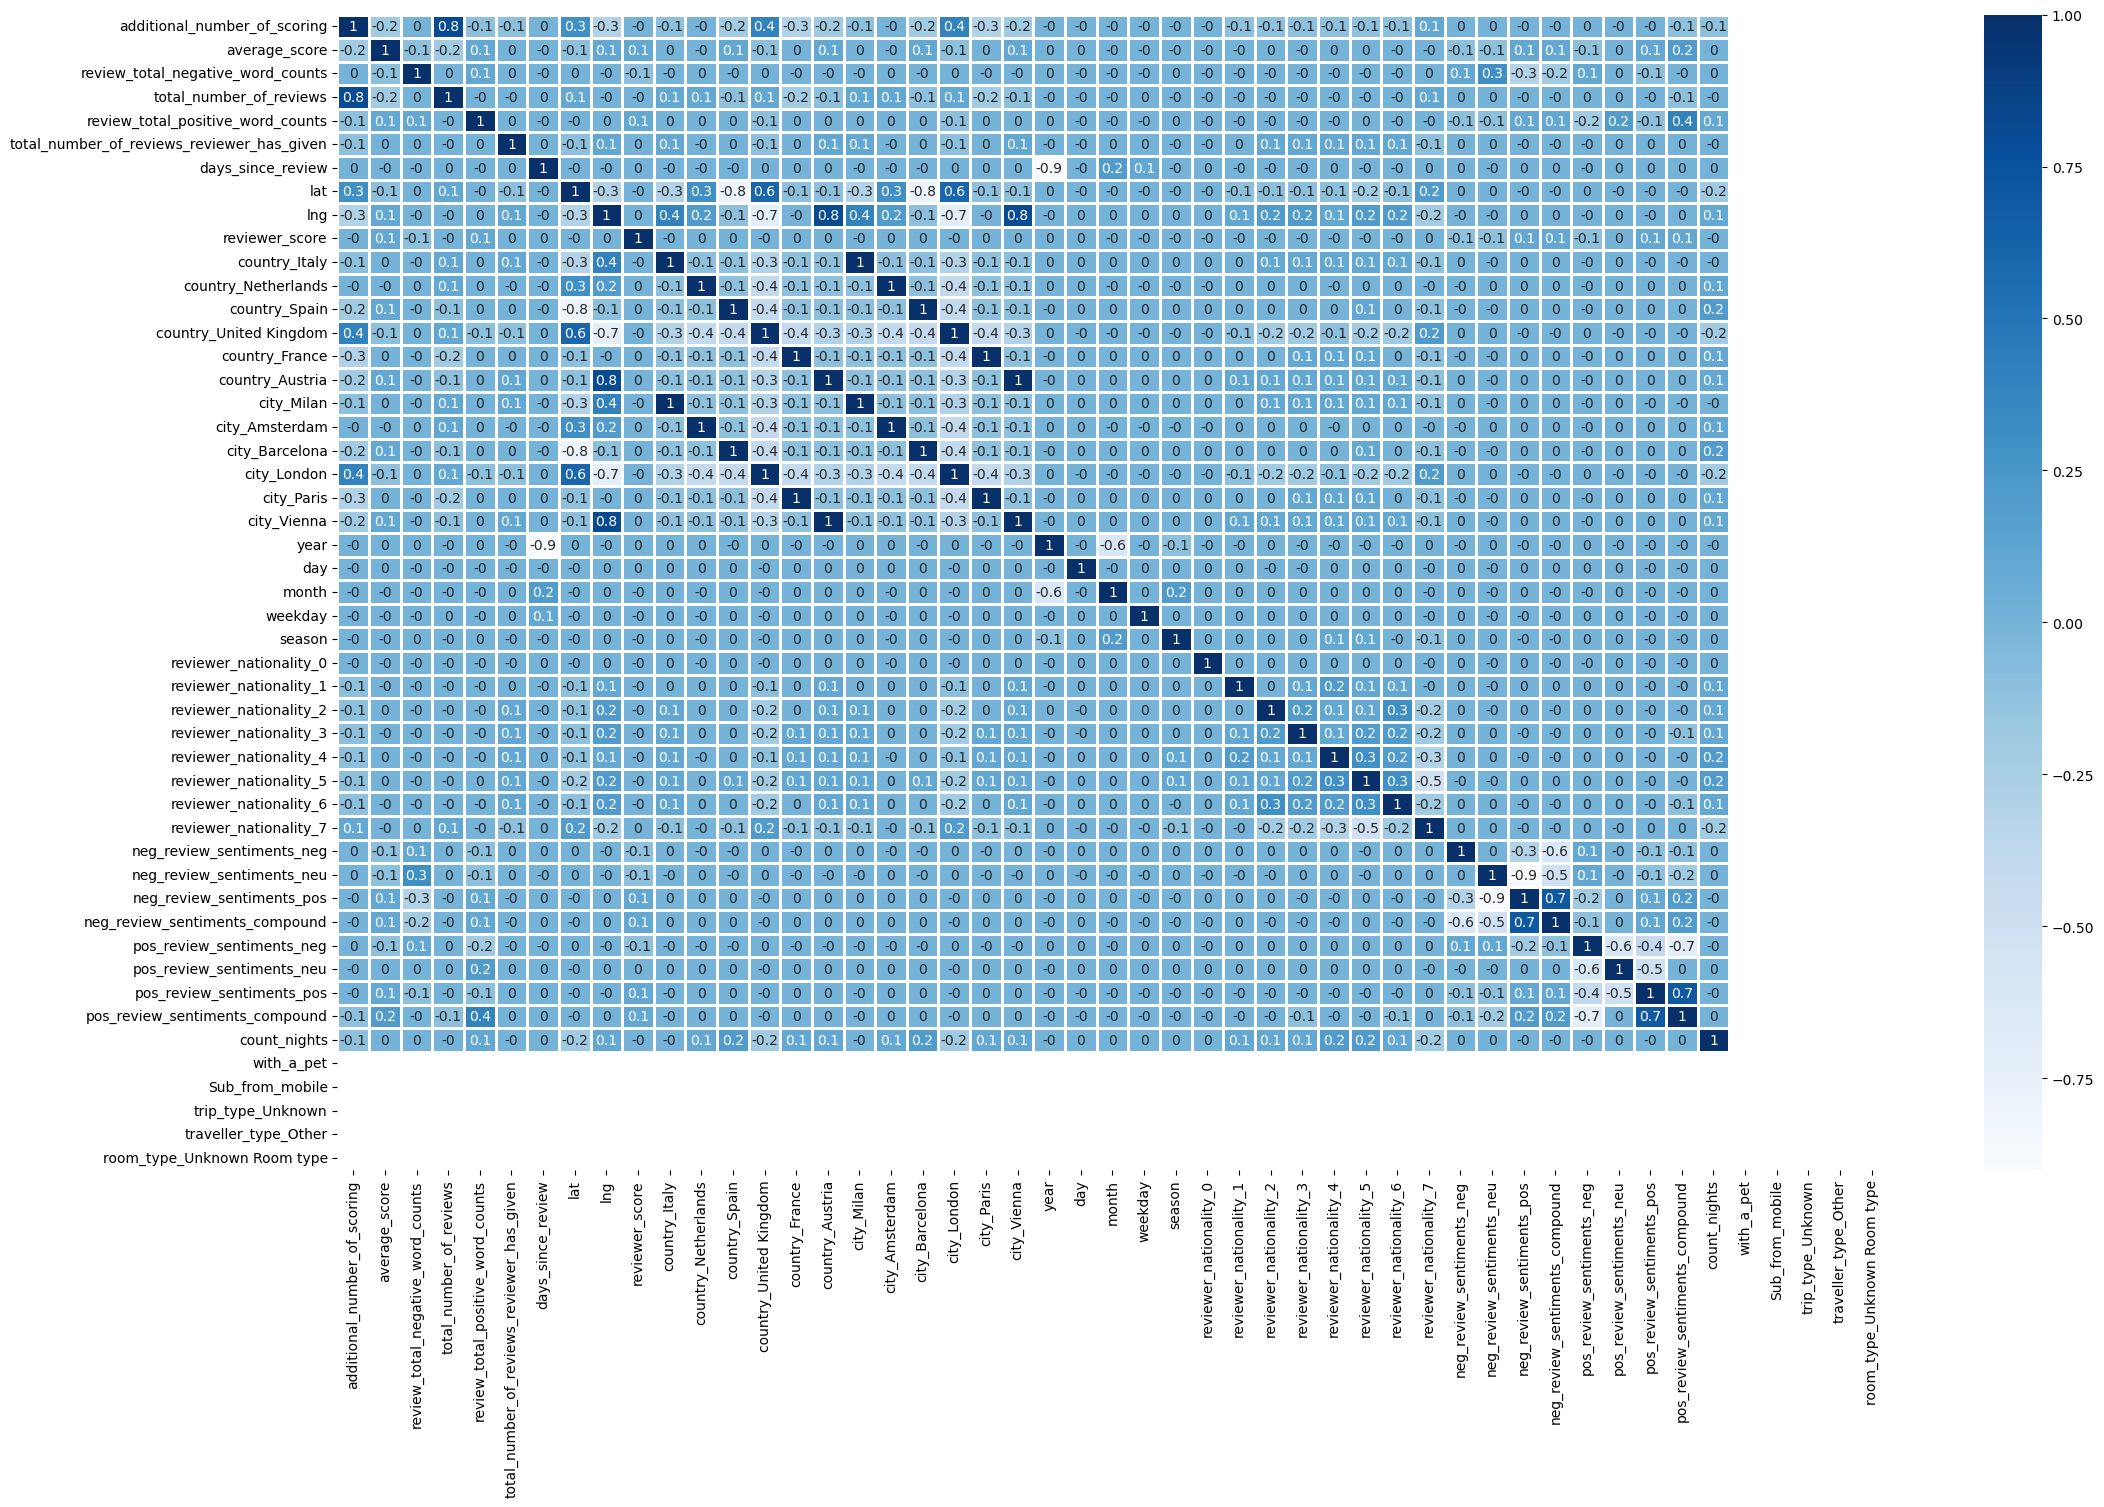

In [60]:
plt.rcParams['figure.figsize'] = (25,15)
sns.heatmap(round(data.drop(['sample'], axis=1).corr(), 1), annot=True, linewidths=2, cmap='Blues')

In [61]:
# убираем признаки с dtypes "object" 
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [62]:
#удаляем признак "review_date"
data.drop('review_date', axis = 1, inplace=True)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int16  
 7   lat                                         512470 non-null  float64
 8   lng                                         512470 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [64]:
#заполняем пропуски нулями
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

In [65]:
data.head(3)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,pos_review_sentiments_neg,pos_review_sentiments_neu,pos_review_sentiments_pos,pos_review_sentiments_compound,count_nights,with_a_pet,Sub_from_mobile,trip_type_Unknown,traveller_type_Other,room_type_Unknown Room type
0,904,8.1,52,16670,62,1,13,45.533137,9.171102,0,...,0.0,0.671,0.329,0.9615,2,0,0,1,1,1
1,612,8.6,10,5018,0,7,234,52.385649,4.834443,0,...,1.0,0.000,0.000,-0.5719,1,0,0,1,1,1
2,46,8.3,3,351,5,15,616,41.393192,2.161520,0,...,0.0,0.260,0.740,0.6908,1,0,0,1,1,1


**Анализ мультиколлинеарности**

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int16  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [67]:
#непрерывные признаки
cols_num=[
    'country_Italy',
    'country_Netherlands',
    'country_Spain', 
    'country_United Kingdom', 
    'country_France', 
    'country_Austria',
    'city_Milan',
    'city_Amsterdam',
    'city_Barcelona',
    'city_London',
    'city_Paris',
    'city_Vienna',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'count_nights',
    'neg_review_sentiments_neg',
    'neg_review_sentiments_neu',
    'neg_review_sentiments_pos',
    'neg_review_sentiments_compound',
    'pos_review_sentiments_neg',
    'pos_review_sentiments_neu',
    'pos_review_sentiments_pos',
    'pos_review_sentiments_compound',
    'lat',
    'lng'
]

# категориальные признаки
cols_cat = [
    'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews',
    'days_since_review',
    'reviewer_nationality_0',
    'reviewer_nationality_1',
    'reviewer_nationality_2',
    'reviewer_nationality_3',
    'reviewer_nationality_4',
    'reviewer_nationality_5',
    'reviewer_nationality_6',
    'reviewer_nationality_7',
    'reviewer_score',
    'season',
    'month',
    'year',
    'day', 
    'weekday',
]

In [68]:
# объявим функцию для построения графиков корреляции
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(25, 20))
    corr = data[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr,
                annot=True,
                linewidths=0.1,
                ax=ax_,
                mask=mask,
                cmap='plasma',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

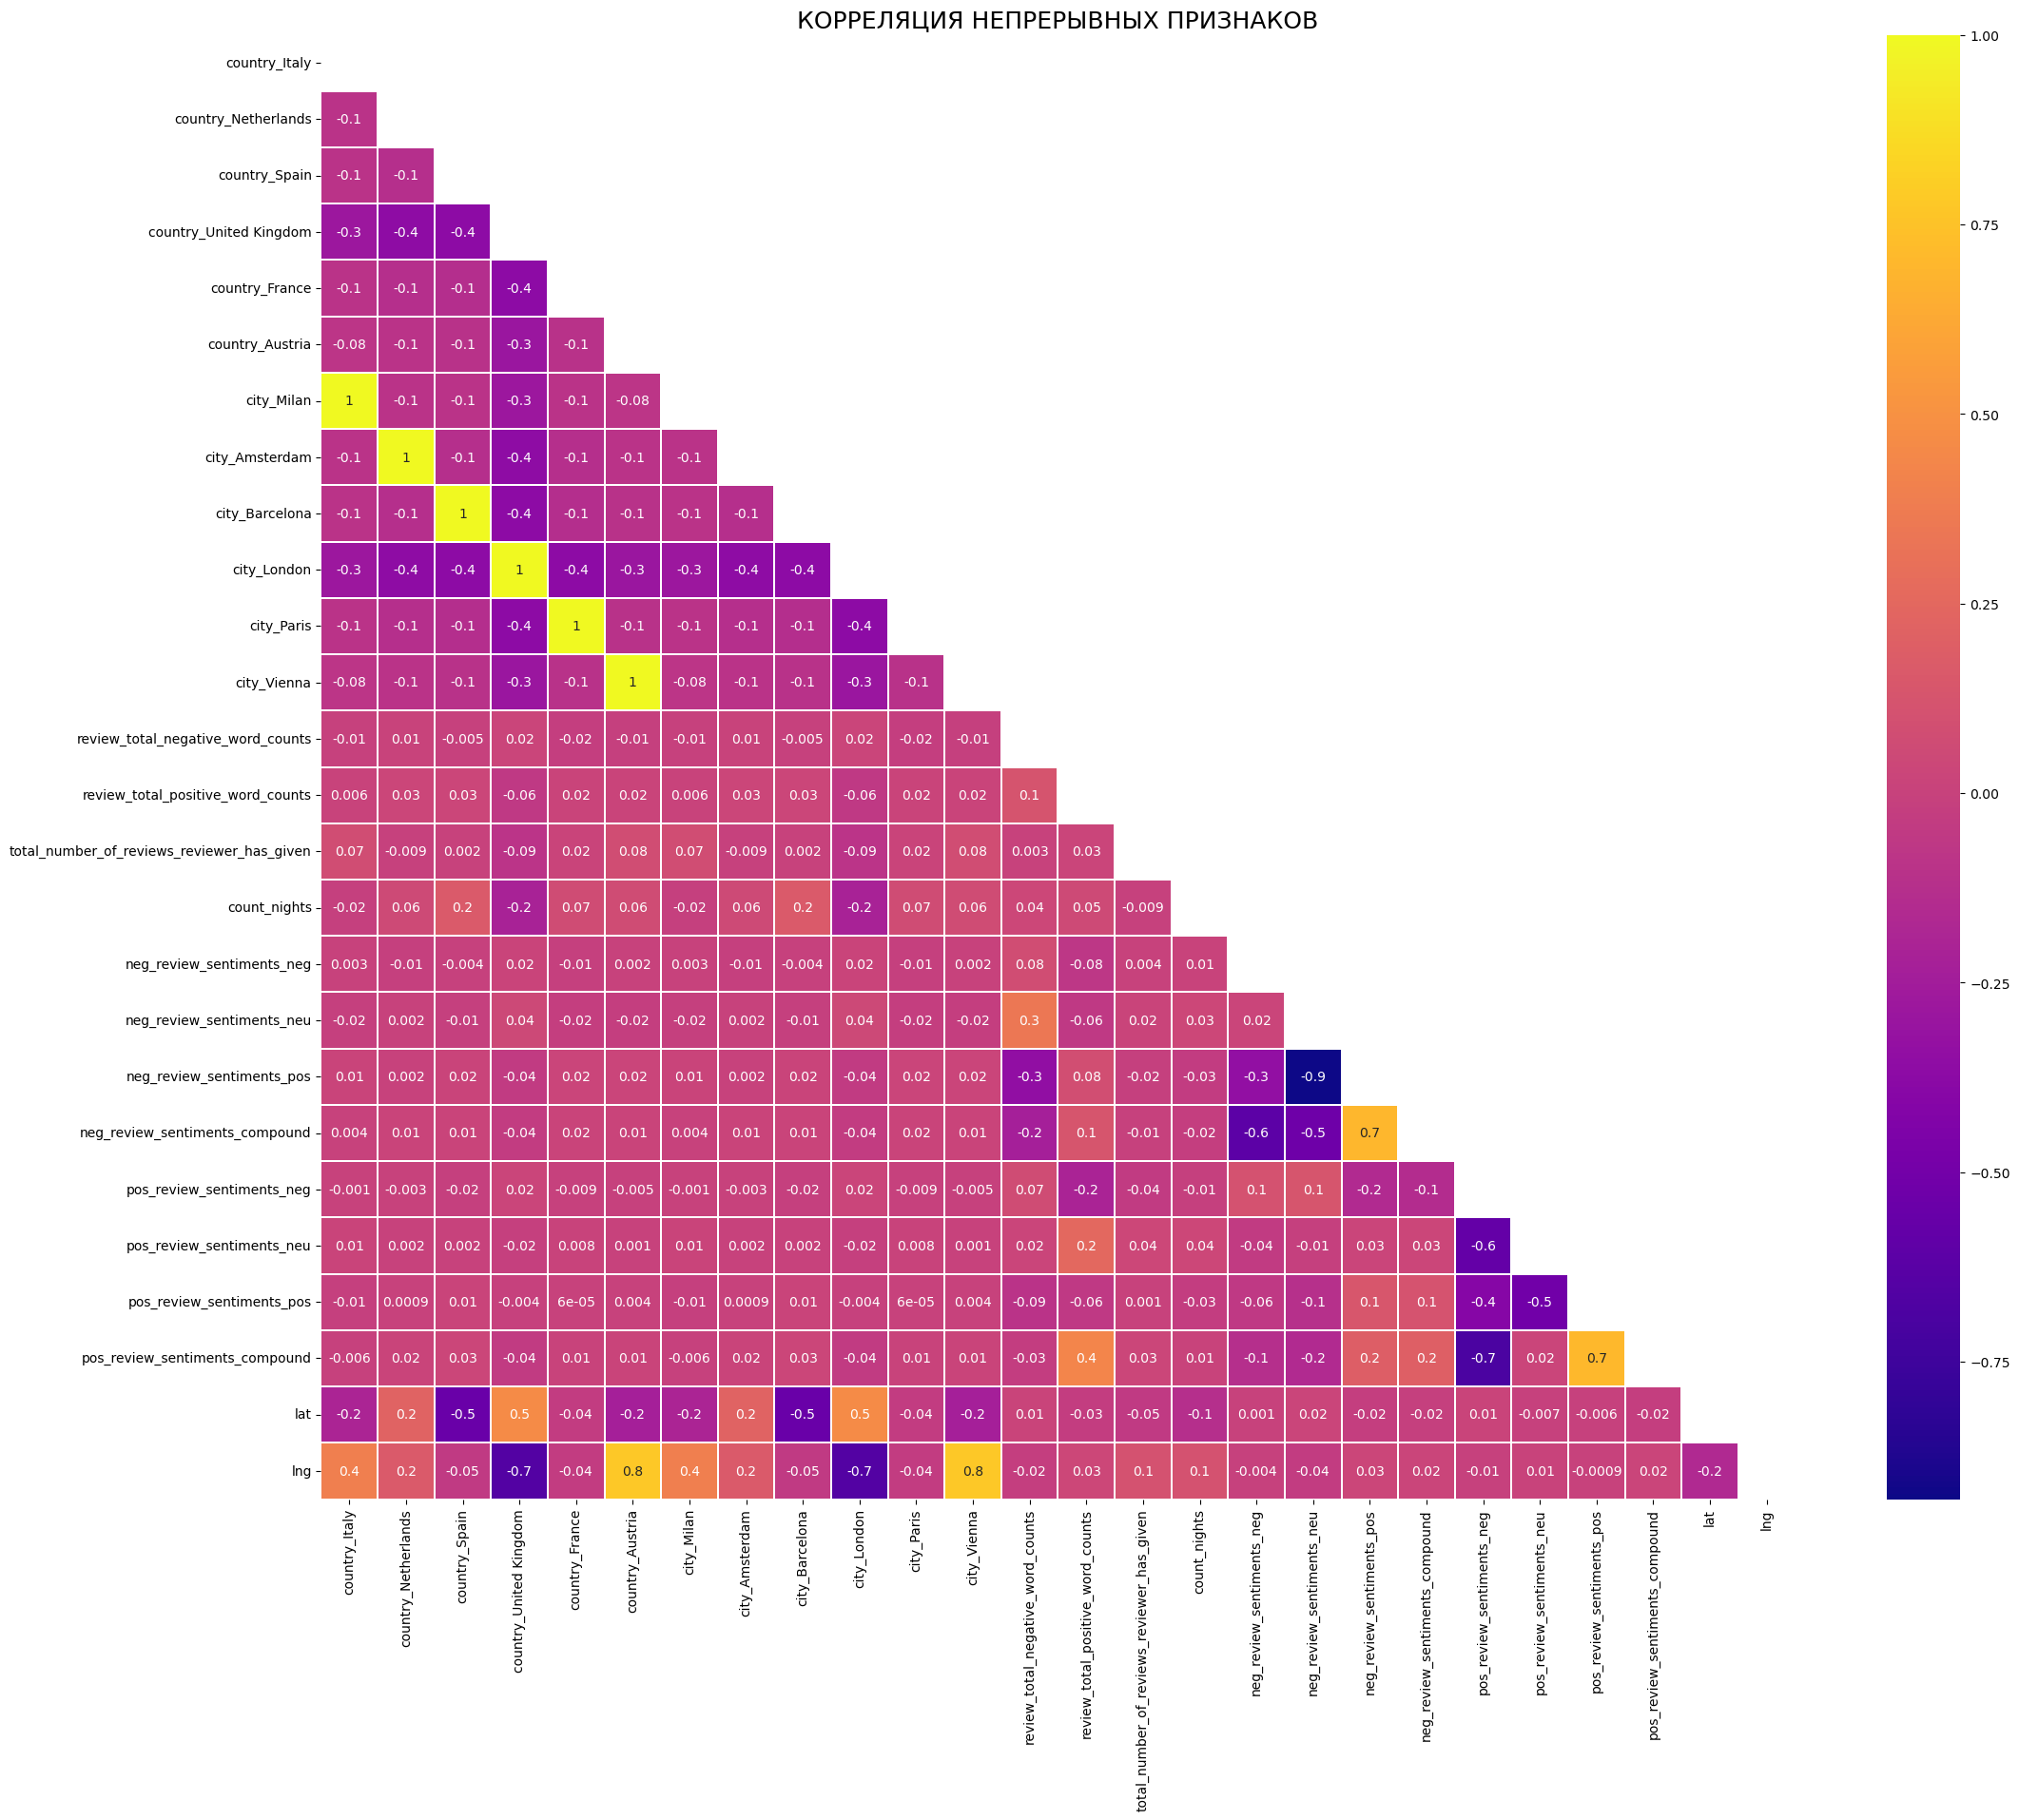

In [70]:
show_corr_heatmap(cols_num, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='pearson')

In [72]:
drop_num = ['country_Italy','country_Netherlands','country_Spain','country_United Kingdom','country_France', 
    'country_Austria','neg_review_sentiments_neu']

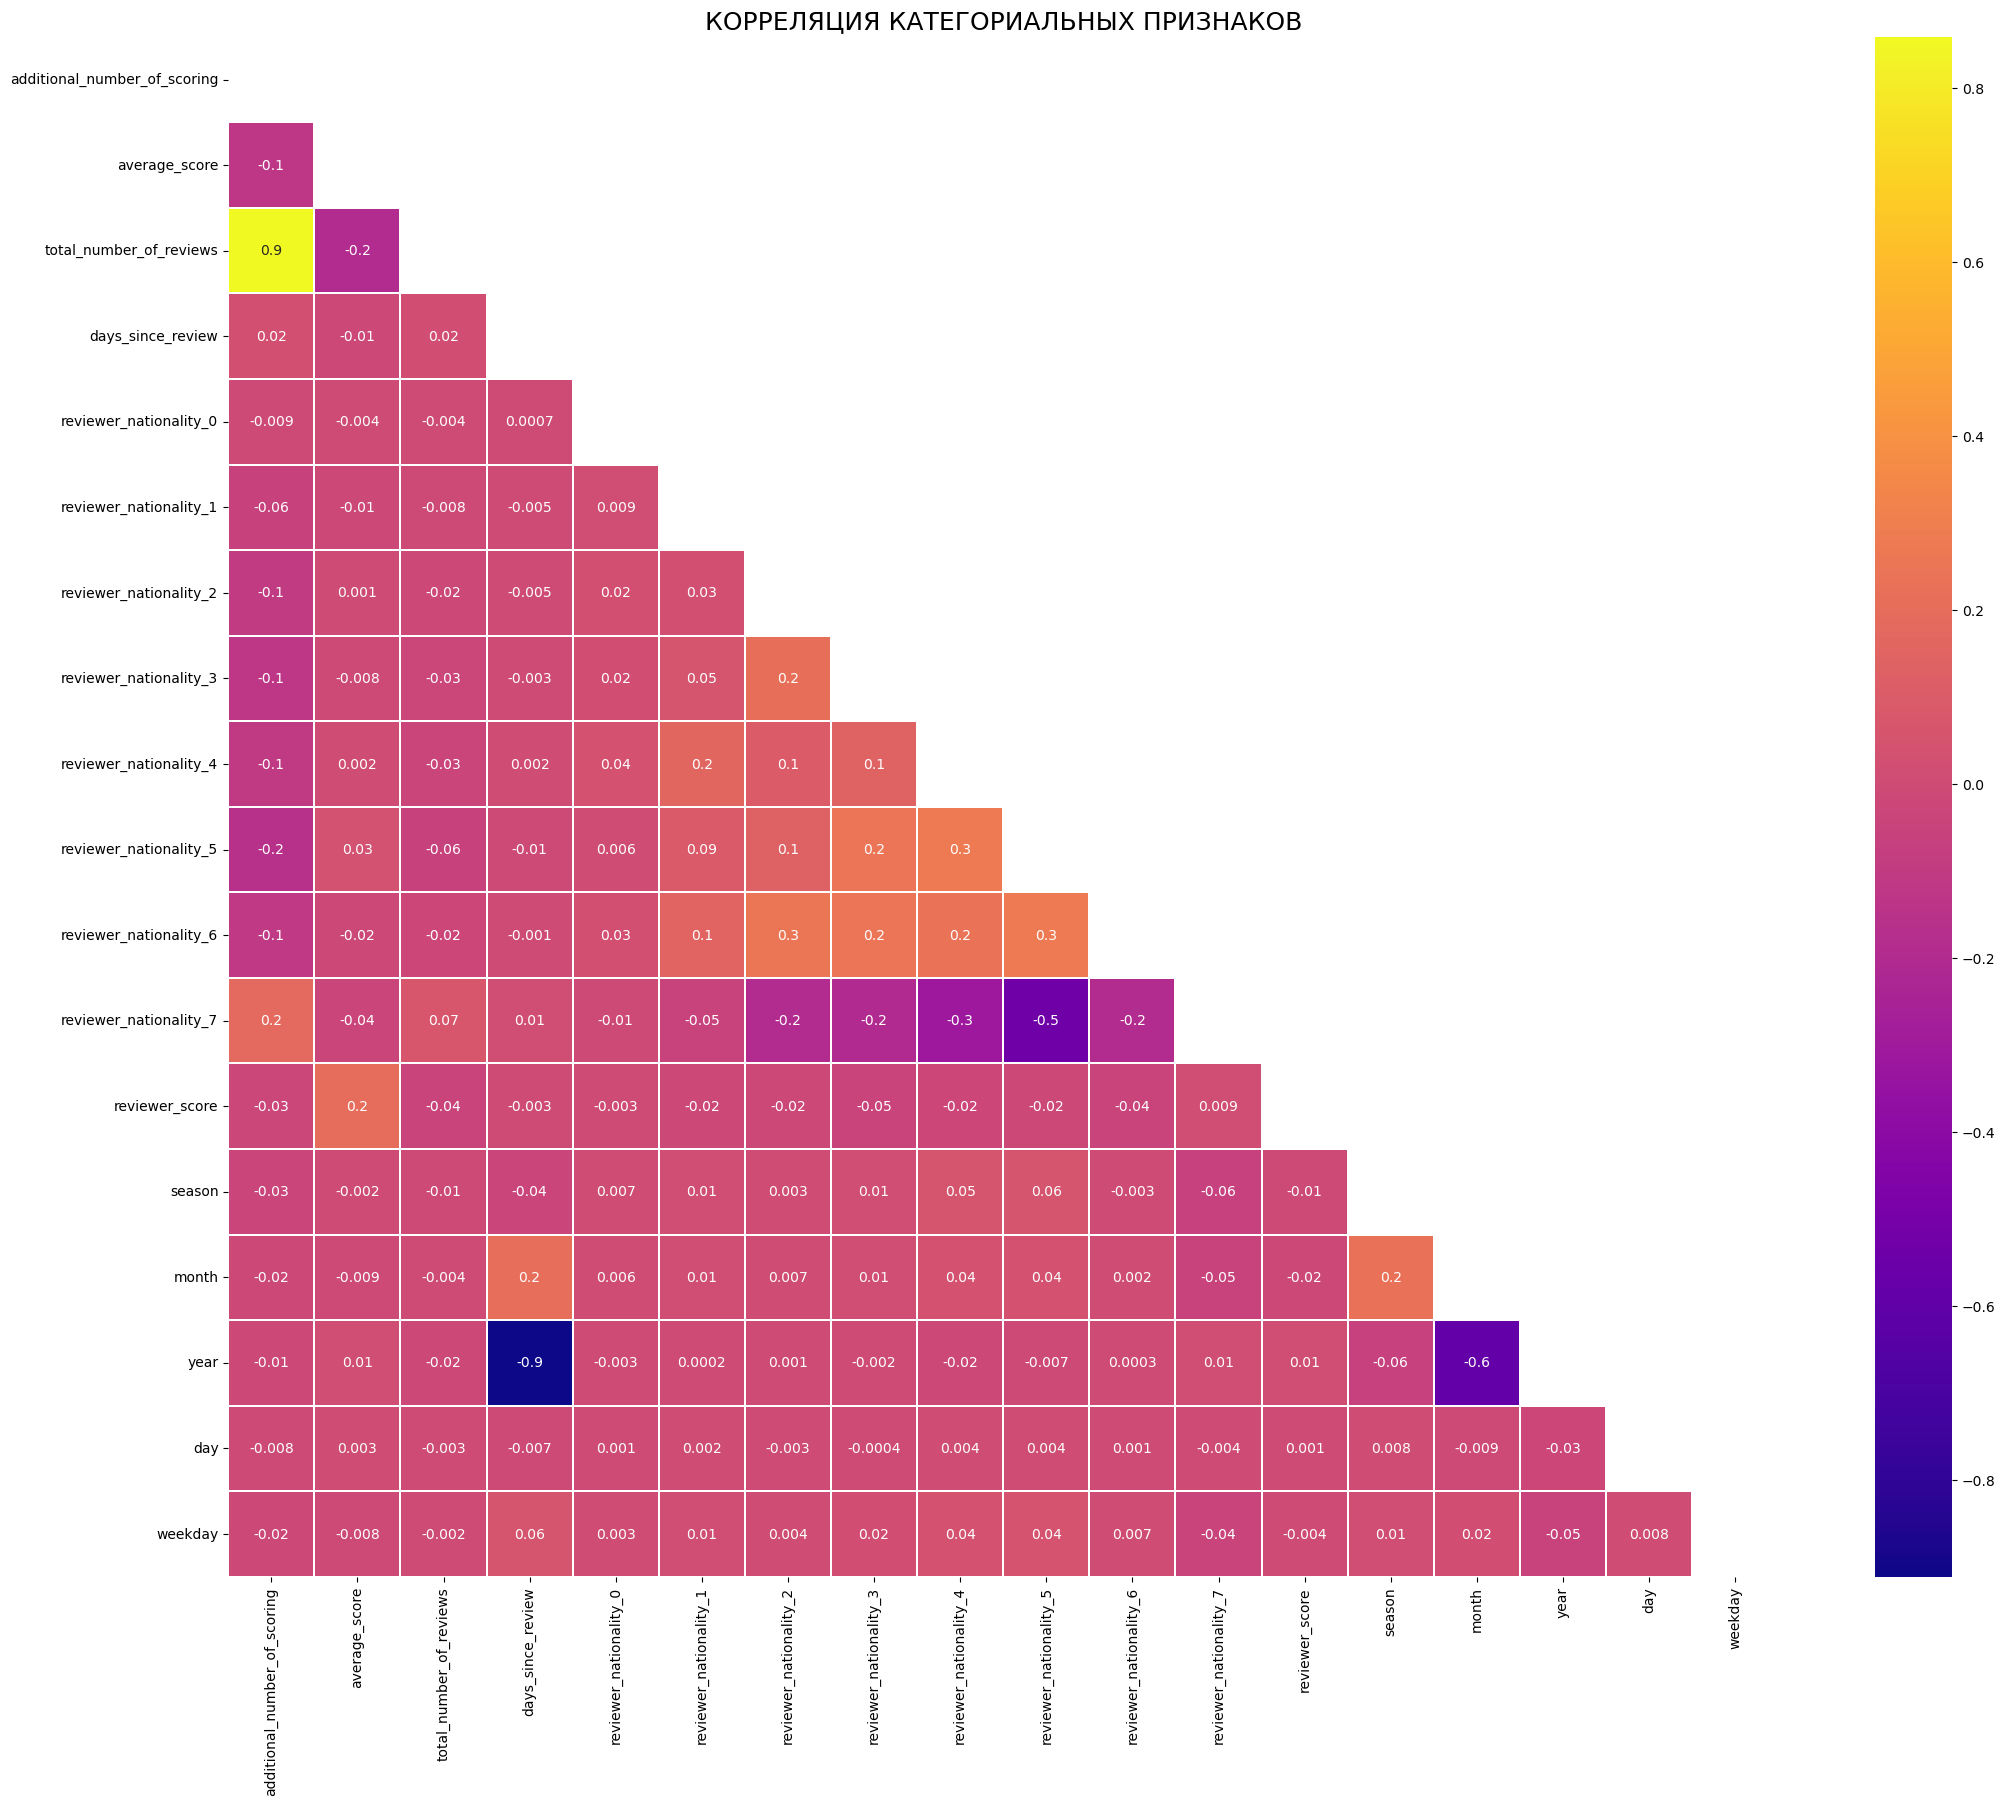

In [73]:
show_corr_heatmap(cols_cat, 'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ', method='spearman')

In [74]:
drop_cat = ['additional_number_of_scoring']

In [77]:
data.drop(drop, axis = 1, inplace=True)

In [75]:
drop = drop_num + drop_cat

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int16  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [80]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values           
X = train_data.drop(['reviewer_score'], axis=1)

In [81]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [82]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 41), (386803, 41), (386803, 40), (309442, 40), (77361, 40))

In [83]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [84]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [85]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [86]:
# Функция для рассчёта MAPE:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Выводим значение MAPE:
print('MAPE:', mape(y_test, y_pred))

MAPE: 12.54162794260208


In [87]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8792605216668171


<AxesSubplot:>

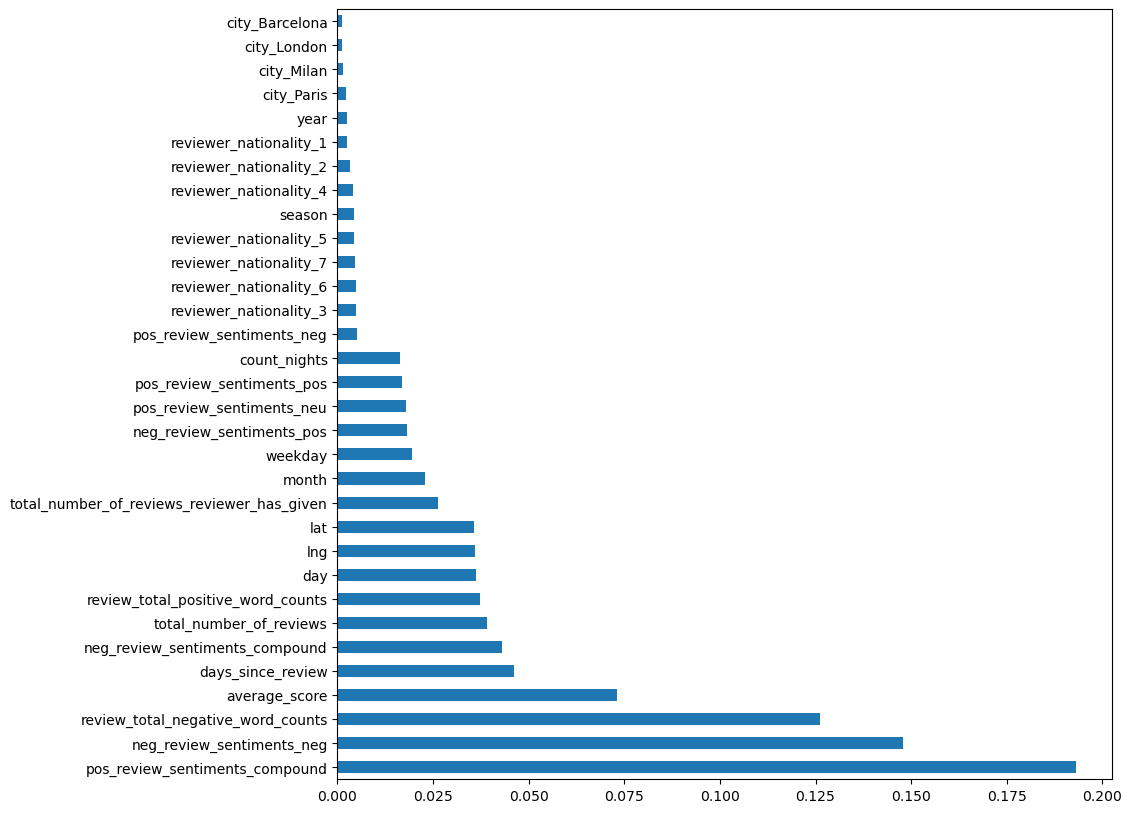

In [88]:
# Выводим важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(32).plot(kind='barh')

In [89]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,city_Milan,...,pos_review_sentiments_neg,pos_review_sentiments_neu,pos_review_sentiments_pos,pos_review_sentiments_compound,count_nights,with_a_pet,Sub_from_mobile,trip_type_Unknown,traveller_type_Other,room_type_Unknown Room type
64918,7.9,0,2037,12,12,620,51.563476,-0.204276,0.0,0,...,0.0,0.182,0.818,0.9511,1,0,0,1,1,1
103392,9.2,50,1772,8,3,476,48.207235,16.372238,0.0,0,...,0.0,0.280,0.720,0.8832,2,0,0,1,1,1
64050,8.5,0,467,53,3,474,48.838982,2.345553,0.0,0,...,0.0,0.838,0.162,0.8439,2,0,0,1,1,1
65791,8.1,13,984,27,7,343,45.502453,9.221836,0.0,1,...,0.0,0.620,0.380,0.9168,1,0,0,1,1,1
89774,8.6,8,4153,27,3,271,41.386529,2.168292,0.0,0,...,0.0,0.617,0.383,0.9195,1,0,0,1,1,1
82841,8.8,0,4887,19,12,8,41.373246,2.147435,0.0,0,...,0.0,0.676,0.324,0.8016,3,0,0,1,1,1
96613,8.5,2,2279,88,29,205,48.204465,16.370240,0.0,0,...,0.0,0.788,0.212,0.9577,3,0,0,1,1,1
13405,8.7,215,7491,12,1,639,51.510841,-0.078058,0.0,0,...,0.0,0.703,0.297,0.5859,1,0,0,1,1,1
29758,8.2,0,1178,4,2,385,45.481492,9.192023,0.0,1,...,0.0,1.000,0.000,0.0000,2,0,0,1,1,1
32547,8.7,0,977,23,14,497,41.370304,2.171410,0.0,0,...,0.0,0.637,0.363,0.8822,2,0,0,1,1,1


In [90]:
#удаляем целевой признак из выборки
test_data = test_data.drop(['reviewer_score'], axis=1)

In [91]:
#сохраняем предсказание модели
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [92]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [93]:
predict_submission

array([8.585, 7.403, 8.637, ..., 8.235, 9.493, 7.228])

In [94]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.585,488440
1,7.403,274649
2,8.637,374688
3,9.766,404352
4,9.700,451596
5,9.075,302161
6,7.272,317079
7,7.154,13963
8,8.406,159785
9,7.198,195089


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int16  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 